# Attention Basics
In this notebook, we look at how attention is implemented. We will focus on implementing attention in isolation from a larger model. That's because when implementing attention in a real-world model, a lot of the focus goes into piping the data and juggling the various vectors rather than the concepts of attention themselves.

We will implement attention scoring as well as calculating an attention context vector.

## Attention Scoring
### Inputs to the scoring function
Let's start by looking at the inputs we'll give to the scoring function. We will assume we're in the first step in the decoging phase. The first input to the scoring function is the hidden state of decoder (assuming a toy RNN with three hidden nodes -- not usable in real life, but easier to illustrate):

In [1]:
dec_hidden_state = [5,1,20]

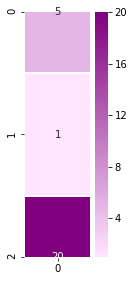

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Let's visualize our decoder hidden state
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)

Our first scoring function will score a single annotation (encoder hidden state), which looks like this:

In [5]:
annotation = [3,12,45] #e.g. Encoder hidden state

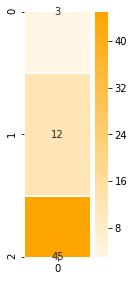

In [6]:
# Let's visualize the single annotation
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)), annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)